In [30]:
from functools import partial
from itertools import starmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter as unifilt

from iEEG_utils.loading import read_data
from iEEG_utils.processing import filtering, fooof_mod
from fooof.utils import interpolate_spectra
# pymultitaper - https://github.com/fncokg/pymultitaper
from pymultitaper import multitaper_spectrogram

rng = np.random.default_rng()

In [2]:
# use file selection dialog to choose folder with data storage
fstr = read_data.select_directory()
print(fstr)

C:\Users\jmile3\OneDrive - SCH\emotional_faces_data\65ea6f\RestingState


In [3]:
# IF following JTM's data processing workflow
#### i.e.: 
#### iEEG.csv of timeseries for regions of interest
#### montage.csv of research montage info
#### channels.csv with metadata (loosely following iEEG-BIDS)
# the next line will load the iEEG.csv file and metadata
# can set load_meta = False to just load the timeseries data
# will need sampling rate, though (typically in "channels.csv")

montage = read_data.load_info(fstr,ftype="montage")
montage.name = montage.name.replace(" ","",regex=True)
srate,data = read_data.load_iEEG(fstr,load_meta=True)
# newcols = list(map(lambda x: x.replace(" ",""),data.columns))
data.rename(mapper=dict(zip(data.columns,list(map(lambda x: x.replace(" ",""),data.columns)))),axis='columns',inplace=True)
origtime = pd.to_datetime(data.time,format='%H:%M:%S.%f')
origts = np.array(origtime-origtime[0])/ np.timedelta64(1, 's')

print(srate)
print(data.shape)

display(data.head())

1000
(271000, 18)


,time,RLW13,RLW14,RY4,RY5,RC1,RC2,RC3,RC4,RC5,RC6,RC9,RC10,RG1,RG2,RG3,RG5,RG6
0,10:13:47.706329,-36.777800,-35.973126,17.068291,-23.165401,-122.408508,-142.860634,-106.516199,-94.647260,-20.013762,-72.854010,-59.308668,-36.978968,-26.249984,-46.903279,-54.547681,-77.279717,-64.337879
1,10:13:47.707329,-35.973126,-34.430835,12.642585,-29.669848,-133.875110,-153.589619,-117.312240,-103.297504,-30.206297,-80.699580,-67.221294,-45.629212,-35.034340,-55.553523,-61.052127,-87.338140,-74.463358
2,10:13:47.708329,-35.906070,-33.693217,8.283935,-39.124765,-139.507827,-157.009483,-120.061542,-101.688156,-30.876859,-78.419671,-64.136711,-44.153977,-34.967284,-54.011231,-57.364039,-87.204027,-75.804481
3,10:13:47.709329,-33.693217,-31.413308,9.692114,-42.678742,-133.472773,-153.187282,-113.355927,-91.294453,-24.238299,-68.763585,-53.139501,-34.632003,-29.133399,-45.226875,-47.037391,-75.402144,-66.953069
4,10:13:47.710329,-27.054658,-26.317040,16.330673,-38.990653,-130.321134,-148.560407,-108.058491,-84.588837,-19.074976,-59.174555,-43.550472,-25.780591,-23.970075,-39.325934,-39.661215,-64.337879,-60.985071


In [5]:
montage

,ID,age,region,ch,name
0,65ea6f,11.17,r_Hip,60,RC1
1,65ea6f,11.17,r_Hip,61,RC2
2,65ea6f,11.17,r_Hip,62,RC3
3,65ea6f,11.17,r_fusiform,63,RC4
4,65ea6f,11.17,r_inferiortemporal,64,RC5
5,65ea6f,11.17,r_inferiortemporal,65,RC6
6,65ea6f,11.17,r_middletemporal,68,RC9
7,65ea6f,11.17,r_middletemporal,69,RC10
8,65ea6f,11.17,r_fusiform,72,RG1
9,65ea6f,11.17,r_fusiform,73,RG2


In [151]:
# rate to resample to (best if power of 2)
resrate = 1024
# upper bound of frequency range (must be < resrate/2)
lpfreq = 150
ch1 = "RC9"
ch2 = "RC10"
ts,reref = filtering.bipolar_reref(data.loc[:,[ch1,ch2]], srate, resrate, lpfreq=lpfreq)


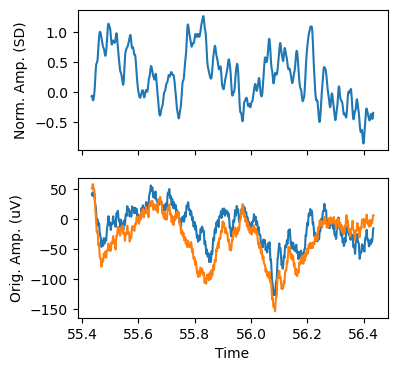

In [157]:
t1 = rng.integers(resrate, high=len(reref))
t0 = t1-resrate
tfilt = (origts>=ts[t0]) & (origts<=ts[t1])
fig, ax = plt.subplots(2,1,sharex=True,figsize=[4,4])
ax[0].plot(ts[t0:t1],reref[t0:t1])
ax[1].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch2],data.loc[tfilt,ch1]]).T,srate,4,[59,61],"stop"))
ax[0].set_xlabel("")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Norm. Amp. (SD)")
ax[1].set_ylabel("Orig. Amp. (uV)")
plt.show()

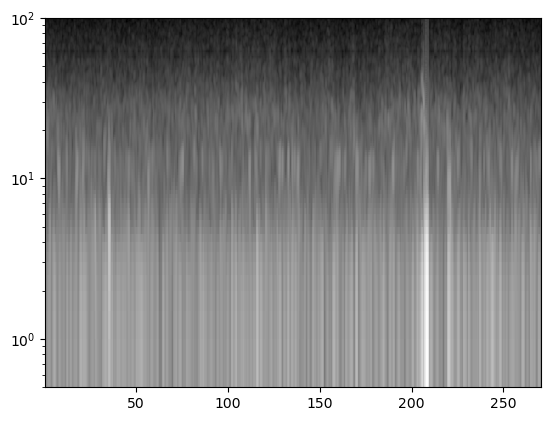

In [158]:
# process data from each subj
# set some parameters that will be used for processing
#####
t_res = 1/4 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 1 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
####

f,sts,spectra = multitaper_spectrogram(reref,resrate,time_step=t_res,window_length=t_win,NW=3,
                                       detrend='off',freq_range=[fmin, fmax],nfft=2*t_win*resrate,
                                       db_scale=False,boundary_pad=False)
# do some light smoothing of adjacent frequencies and timepoints
# (rows are temporally adjacent with t_res (sec) offset. should technically split by region/id)
smoothspect = unifilt(spectra, [5,3], mode="nearest",)
# interpolate over 60 Hz line noise to make fitting better
_,spectra = interpolate_spectra(f, smoothspect.T, [58.5,61.5], buffer=5)
fig, ax = plt.subplots()
ax.pcolormesh(sts,f,np.log10(spectra[1:,1:].T),cmap="grey", shading="flat")
ax.set_ylim([fmin,fmax])
ax.set_yscale("log")
plt.show()

In [159]:
# fit 1/f with Lorentzian
spect_fits = fooof_mod.fit_group(f,spectra)


Running FOOOFGroup across 1081 power spectra.


In [160]:
model_spect = fooof_mod.model_spect
intfs = np.concatenate((np.linspace(0.5,1,sum(f>50)+1),np.linspace(1.05,10,sum(f>10)),f[f>10]))
rowixs = [[ix] for ix in range(max(spectra.shape))]
partial_func = partial(model_spect,model_obj=spect_fits,freqs=f,intfs=intfs,save_fit=True)
calc_resids = starmap(partial_func,rowixs)
resid_spects = np.array(list(calc_resids))

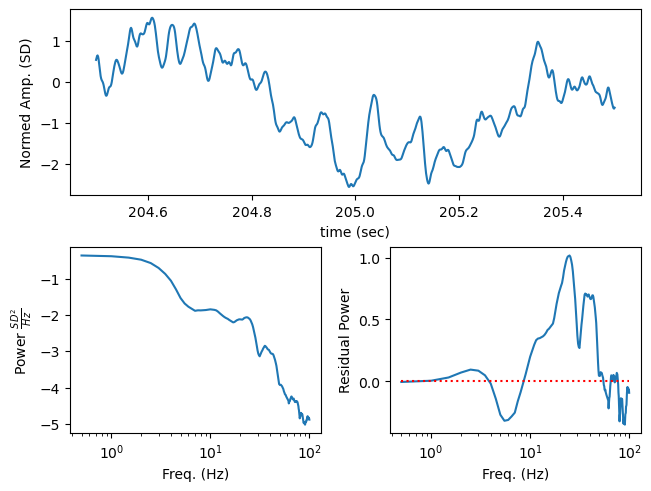

In [161]:
randix = rng.integers(0, high=max(resid_spects.shape))
randt = sts[randix]
plot_ixs = (ts>=randt-(t_win/2))&(ts<=randt+(t_win/2))

fig = plt.figure(layout="constrained")

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(ts[plot_ixs],reref[plot_ixs])
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("Normed Amp. (SD)")

ax2.plot(f,np.log10(spectra[randix,:]))
ax2.set_xscale("log")
ax2.set_xlabel("Freq. (Hz)")
ax2.set_ylabel("Power "+ r'$\frac{SD^2}{Hz}$')

ax3.plot(f,resid_spects[randix,:])
ax3.plot([f[0],f[-1]],[0,0],"r:")
ax3.set_xlabel("Freq. (Hz)")
ax3.set_ylabel("Residual Power")
ax3.set_xscale("log")

In [197]:
t0 = 32
t1 = 34 #max(ts)
tfilt = (ts>t0) & (ts<=t1)
stfilt = (sts>=t0) & (sts<=t1)


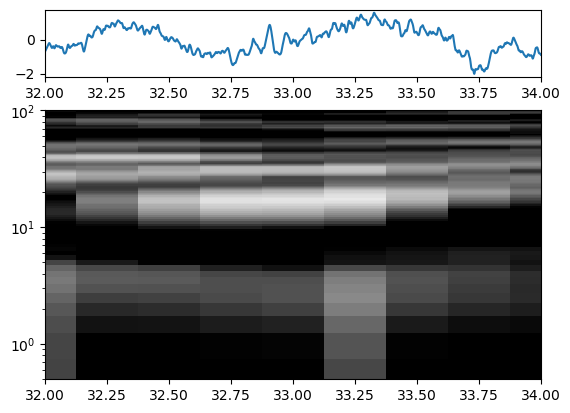

In [198]:
from matplotlib.gridspec import GridSpec
fig = plt.figure()
grid = GridSpec(2,1 , height_ratios=[1,4])
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1],sharex=ax1)

ax1.plot(ts[tfilt],reref[tfilt])
ax1.set_xlim([t0,t1])     
Y,X=np.meshgrid(f, sts[stfilt])
ax2.pcolormesh(X,Y,resid_spects[stfilt,:],vmin=0, vmax=1,
              cmap="grey",shading="nearest")
ax2.set_ylim([fmin,fmax])
ax2.set_yscale("log")
plt.show()